In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#Read CSV
!curl -L -o car_data.csv https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/car_data.csv
df = pd.read_csv('car_data.csv')
#Remove colums 'Car_name' and 'Owner'
df = df.drop(columns={'Car_Name', 'Owner'})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18812  100 18812    0     0  91619      0 --:--:-- --:--:-- --:--:-- 91765


$\textbf{a)}$ Se identifican los conjuntos de entrenamiento, validación y test, y se calcula la proporción de categorías en variables cualitativas.

In [6]:
#Divide by sets
df_trainning = df[df['Set'] == 'Train']
df_validation = df[df['Set'] == 'Validation']
df_test = df[df['Set'] == 'Test']

#Probabilities
p_trainning = len(df_trainning['Set'])/len(df['Set'])
p_validation = len(df_validation['Set'])/len(df['Set'])
p_test = len(df_test['Set'])/len(df['Set'])

#Display
print(f'Probability of set: train, P: {p_trainning}')
print(f'Probability of set: validation, P: {p_validation}')
print(f'Probability of set: test, P: {p_test}')

Probability of set: train, P: 0.8970099667774086
Probability of set: validation, P: 0.03322259136212625
Probability of set: test, P: 0.06976744186046512


In [7]:
#Divide by categories
df_dealer = df[df['Seller_Type'] == 'Dealer']
df_fuel_diesel = df[df['Fuel_Type'] == 'Diesel']
df_fuel_gnc = df[df['Fuel_Type'] == 'CNG']
df_transmision = df[df['Transmission'] == 'Automatic']

#Probabilities
p_seller_dealer = len(df_dealer['Seller_Type'])/len(df['Seller_Type'])
p_fuel_diesel = len(df_fuel_diesel['Fuel_Type'])/len(df['Fuel_Type'])
p_fuel_gnc = len(df_fuel_gnc['Fuel_Type'])/len(df['Fuel_Type'])
p_transmission_auto = len(df_transmision['Transmission'])/len(df['Transmission'])

#Display
print(f'Probability of seller type: dealer, P = {p_seller_dealer}')
print(f'Probability of seller type: individual, P = {1 - p_seller_dealer}')
print(f'Probability of fuel type: diesel, P = {p_fuel_diesel}')
print(f'Probability of fuel type: gnc, P = {p_fuel_gnc}')
print(f'Probability of seller type: petrol, P = {1 - p_fuel_diesel - p_fuel_gnc}')
print(f'Probability of seller type: automatic, P = {p_transmission_auto}')
print(f'Probability of seller type: manual, P = {1 - p_transmission_auto}')

Probability of seller type: dealer, P = 0.6478405315614618
Probability of seller type: individual, P = 0.3521594684385382
Probability of fuel type: diesel, P = 0.19933554817275748
Probability of fuel type: gnc, P = 0.006644518272425249
Probability of seller type: petrol, P = 0.7940199335548173
Probability of seller type: automatic, P = 0.132890365448505
Probability of seller type: manual, P = 0.867109634551495


$\textbf{b)}$Pre-procesamiento:

-Variables categóricas: Se convierten a formato numérico mediante OneHotEncoder.

-Variables numéricas: Se generan términos polinómicos hasta grado 3 para capturar relaciones no lineales.

-Normalización: Se estandarizan las variables para que tengan media 0 y varianza 1, evitando que la escala afecte la regresión.

Dado que Seller_Tipe y Transmission son valriables binarias, es decir solo tienen dos casos, al usar OneHotEncode() coloco un drop para evitar repeticiones.

In [8]:
#b)Pre-procesamiento
#Categorical variables
categorical_features = ['Seller_Type', 'Fuel_Type', 'Transmission']
numeric_features = ['Year', 'Kms_Driven', 'Present_Price']
target = 'Selling_Price'

#Transformation definition:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='if_binary'), categorical_features),  #drop avoid repetitions
        ('num', PolynomialFeatures(degree=3, include_bias=False), numeric_features)  #3rd grade polynomial
    ]
)

#Normalization
scaler = StandardScaler()

$\textbf{c)}$ Regresión lineal:

-Se ajusta un modelo lineal a las variables transformadas mediante el pipeline.

-Se evalúa el modelo con MSE en entrenamiento y validación.

El pipeline, cada paso, transforma los datos y los pasa al siguiente. Así se asegura que todo el preprocesamiento y el modelo se apliquen de forma ordenada y consistente tanto en entrenamiento como en predicción

-Preprocessor

1.Toma las variables categóricas y aplica OneHotEncoder.

2.Toma las variables numéricas y aplica PolynomialFeatures de grado 3.

3.Devuelve una matriz numérica lista para escalar.

-Scaler

1.Estandariza todas las variables (media 0, varianza 1).

-Regressor

1.Ajusta un modelo lineal sobre las variables ya transformadas y escaladas.


In [9]:
#c)Linear Regresion
#Complete pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', scaler),
    ('regressor', LinearRegression())
])

X_train = df_trainning.drop(columns=['Selling_Price', 'Set'])
y_train = df_trainning['Selling_Price']
X_val = df_validation.drop(columns=['Selling_Price', 'Set'])
y_val = df_validation['Selling_Price']
#Trainning with Train
model.fit(X_train, y_train)
#Predict
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
#Errors
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

print("MSE Train:", mse_train)
print("MSE Validation:", mse_val)

MSE Train: 0.47269235595274556
MSE Validation: 0.5419991553243808


$\textbf{d)}$Regularización (Ridge):

-Se agrega un término de penalización sobre los coeficientes del modelo para evitar overfitting.

-Se prueban distintos valores de λ, se selecciona el que minimiza el error.

Con lambda muy chico tengo baja penalizacion y una varianza alta, causando un overfitting. Mientras que un lambda alto puede causar un underfitting, aumentado el MSE.

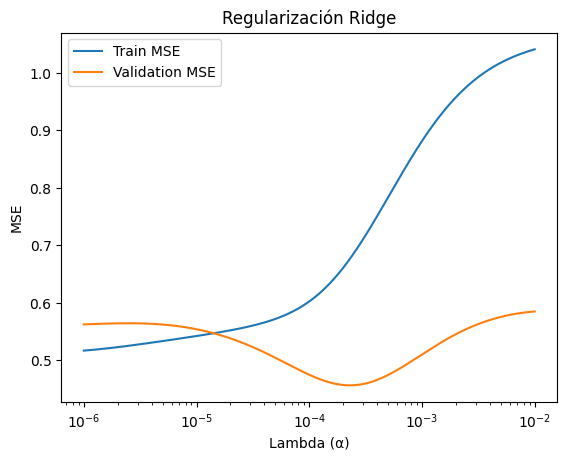

Best λ: 0.0002332883097864156 with MSE 0.45670517268339184


In [10]:
#d)Regularizacion
lambdas = np.logspace(-6, -2, 300)  #1e-6 < lambda < 1e-2
mse_train_list = []
mse_val_list = []

for lam in lambdas:
    ridge_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('regressor', Ridge(alpha=lam))
    ])
    #Trainning
    ridge_model.fit(X_train, y_train)
    #Predict
    y_pred_train = ridge_model.predict(X_train)
    y_pred_val = ridge_model.predict(X_val)
    #Mean cuadratic error
    mse_train_list.append(mean_squared_error(y_train, y_pred_train))
    mse_val_list.append(mean_squared_error(y_val, y_pred_val))

#Plot MSE evolution through lambda
plt.plot(lambdas, mse_train_list, label="Train MSE")
plt.plot(lambdas, mse_val_list, label="Validation MSE")
plt.xscale("log")
plt.xlabel("Lambda (α)")
plt.ylabel("MSE")
plt.title("Regularización Ridge")
plt.legend()
plt.show()

#Best lambda
best_idx = np.argmin(mse_val_list)
print(f"Best λ: {lambdas[best_idx]} with MSE {mse_val_list[best_idx]}")
